<a href="https://colab.research.google.com/github/tranduytruong12/Facial-emotion-recognition/blob/main/Facial_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Create the Kaggle directory
!mkdir -p ~/.kaggle

# Move the kaggle.json file into the Kaggle directory
!cp kaggle.json ~/.kaggle/

# Set the permissions of the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

# Unzip the dataset
!unzip face-expression-recognition-dataset.zip -d face_expression_data

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: face_expression_data/images/validation/fear/8797.jpg  
  inflating: face_expression_data/images/validation/fear/8818.jpg  
  inflating: face_expression_data/images/validation/fear/886.jpg  
  inflating: face_expression_data/images/validation/fear/9037.jpg  
  inflating: face_expression_data/images/validation/fear/9040.jpg  
  inflating: face_expression_data/images/validation/fear/9101.jpg  
  inflating: face_expression_data/images/validation/fear/911.jpg  
  inflating: face_expression_data/images/validation/fear/9179.jpg  
  inflating: face_expression_data/images/validation/fear/9205.jpg  
  inflating: face_expression_data/images/validation/fear/9232.jpg  
  inflating: face_expression_data/images/validation/fear/9251.jpg  
  inflating: face_expression_data/images/validation/fear/9261.jpg  
  inflating: face_expression_data/images/validation/fear/9281.jpg  
  inflating: face_expression_data/images/validation/fear/9302

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [42]:
train_dir = 'face_expression_data/images/train'
val_dir = 'face_expression_data/images/validation'

In [43]:
# Load as a TensorFlow dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),        # Resize images
    color_mode='grayscale',     # Grayscale images
    batch_size=32,               # Only 1 image per batch
    shuffle=True                # Shuffle so you get a random image
)

test_dataset =tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(48, 48),        # Resize images
    color_mode='grayscale',     # Grayscale images
    batch_size=32,               # Only 1 image per batch
    shuffle=True                # Shuffle so you get a random image
)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [61]:
import tensorflow as tf
import os

# Assuming train_dir and val_dir are the paths to your training and validation directories
# Replace these with your actual directory paths if different
train_dir = 'face_expression_data/images/train'
val_dir = 'face_expression_data/images/validation'

# Get class names from the directories
class_names = sorted(os.listdir(train_dir))
print("Class names (in alphabetical order):", class_names)

# Count samples in each class for training set
print("\nTraining set:")
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    num_samples = len(os.listdir(class_path))
    print(f"  {class_name}: {num_samples} images")

# Total training samples
total_train = sum(len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names)
print(f"Total training samples: {total_train}")

# Count samples in each class for validation set
print("\nValidation set:")
for class_name in class_names:
    class_path = os.path.join(val_dir, class_name)
    num_samples = len(os.listdir(class_path))
    print(f"  {class_name}: {num_samples} images")

# Total validation samples
total_val = sum(len(os.listdir(os.path.join(val_dir, class_name))) for class_name in class_names)
print(f"Total validation samples: {total_val}")

# Alternatively, if you already have the datasets loaded:
print("\nClass distribution from loaded datasets:")
print("Training dataset:")
for label, class_name in enumerate(train_dataset.class_names):
    # Count samples with this label
    count = sum(1 for _, labels_batch in train_dataset for label_idx in labels_batch.numpy() if label_idx == label)
    print(f"  {class_name}: {count} images")

print("\nValidation dataset:")
for label, class_name in enumerate(test_dataset.class_names):
    # Count samples with this label
    count = sum(1 for _, labels_batch in test_dataset for label_idx in labels_batch.numpy() if label_idx == label)
    print(f"  {class_name}: {count} images")

Class names (in alphabetical order): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Training set:
  angry: 3993 images
  disgust: 436 images
  fear: 4103 images
  happy: 7164 images
  neutral: 4982 images
  sad: 4938 images
  surprise: 3205 images
Total training samples: 28821

Validation set:
  angry: 960 images
  disgust: 111 images
  fear: 1018 images
  happy: 1825 images
  neutral: 1216 images
  sad: 1139 images
  surprise: 797 images
Total validation samples: 7066

Class distribution from loaded datasets:
Training dataset:
  angry: 3993 images
  disgust: 436 images
  fear: 4103 images
  happy: 7164 images
  neutral: 4982 images
  sad: 4938 images
  surprise: 3205 images

Validation dataset:
  angry: 960 images
  disgust: 111 images
  fear: 1018 images
  happy: 1825 images
  neutral: 1216 images
  sad: 1139 images
  surprise: 797 images


(32, 48, 48, 1)


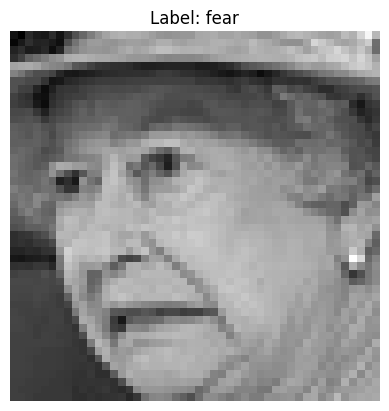

In [45]:
# Get one batch (i.e., one image and its label)
for images, labels in train_dataset.take(1):
    print(images.shape)
    image = images[0].numpy().squeeze()   # remove batch and channel dimension
    label = labels[0].numpy()

    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {train_dataset.class_names[label]}")
    plt.axis('off')
    plt.show()

## CNN

In [46]:
no_of_classes=7

model=Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding="same",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


#2nd CNN layer
model.add(Conv2D(128,(5,5),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes,activation="softmax"))

opt = Adam(learning_rate=0.0001)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [47]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
# Set paths
checkpoint_path = 'best_model.h5'

# Callbacks
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_delta=1e-4,
    min_lr=1e-7
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)



In [48]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[lr_reduce, early_stop, checkpoint]
)

Epoch 1/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2740 - loss: 1.9115
Epoch 1: val_loss improved from inf to 1.55456, saving model to best_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 45s 35ms/step - accuracy: 0.2741 - loss: 1.9113 - val_accuracy: 0.3796 - val_loss: 1.5546 - learning_rate: 0.0010
Epoch 2/30
899/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4523 - loss: 1.4149
Epoch 2: val_loss did not improve from 1.55456
901/901 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.4523 - loss: 1.4147 - val_accuracy: 0.4016 - val_loss: 1.5554 - learning_rate: 0.0010
Epoch 3/30
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5082 - loss: 1.2726
Epoch 3: val_loss improved from 1.55456 to 1.40816, saving model to best_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.5082 - loss: 1.2726 - val_accuracy: 0.4291 - val_loss: 1.4082 - learning_rate: 0.0010
Epoch 4/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5393 - loss: 1.2054
Epoch 4: val_loss improved from 1.40816 to 1.28893, saving model to best_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.5393 - loss: 1.2054 - val_accuracy: 0.5177 - val_loss: 1.2889 - learning_rate: 0.0010
Epoch 5/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5693 - loss: 1.1454
Epoch 5: val_loss improved from 1.28893 to 1.27382, saving model to best_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5693 - loss: 1.1454 - val_accuracy: 0.5147 - val_loss: 1.2738 - learning_rate: 0.0010
Epoch 6/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5854 - loss: 1.0962
Epoch 6: val_loss did not improve from 1.27382
901/901 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.5854 - loss: 1.0962 - val_accuracy: 0.5006 - val_loss: 1.3459 - learning_rate: 0.0010
Epoch 7/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6037 - loss: 1.0461
Epoch 7: val_loss improved from 1.27382 to 1.09396, saving model to best_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.6037 - loss: 1.0460 - val_accuracy: 0.5899 - val_loss: 1.0940 - learning_rate: 0.0010
Epoch 8/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6315 - loss: 0.9880
Epoch 8: val_loss did not improve from 1.09396
901/901 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6315 - loss: 0.9880 - val_accuracy: 0.5426 - val_loss: 1.1898 - learning_rate: 0.0010
Epoch 9/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6485 - loss: 0.9403
Epoch 9: val_loss improved from 1.09396 to 1.06759, saving model to best_model.h5


901/901 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6485 - loss: 0.9403 - val_accuracy: 0.6032 - val_loss: 1.0676 - learning_rate: 0.0010
Epoch 10/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6591 - loss: 0.8948
Epoch 10: val_loss did not improve from 1.06759
901/901 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6591 - loss: 0.8948 - val_accuracy: 0.5061 - val_loss: 1.3889 - learning_rate: 0.0010
Epoch 11/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6884 - loss: 0.8260
Epoch 11: val_loss did not improve from 1.06759
901/901 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6885 - loss: 0.8260 - val_accuracy: 0.5059 - val_loss: 1.4001 - learning_rate: 0.0010
Epoch 12/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7083 - loss: 0.7793
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 12: val_loss did not improve from 1.06759
901/901 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7083 - loss: 0.7793 - val_a

901/901 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.7440 - loss: 0.6902 - val_accuracy: 0.6458 - val_loss: 1.0317 - learning_rate: 1.0000e-04
Epoch 14/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7678 - loss: 0.6244
Epoch 14: val_loss did not improve from 1.03168
901/901 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7678 - loss: 0.6243 - val_accuracy: 0.6470 - val_loss: 1.0415 - learning_rate: 1.0000e-04
Epoch 15/30
901/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7814 - loss: 0.5853
Epoch 15: val_loss did not improve from 1.03168
901/901 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.7814 - loss: 0.5853 - val_accuracy: 0.6527 - val_loss: 1.0475 - learning_rate: 1.0000e-04
Epoch 16/30
900/901 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7874 - loss: 0.5656
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 16: val_loss did not improve from 1.03168
901/901 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7875 - loss: 0.

In [58]:
model.save('my_model.keras')

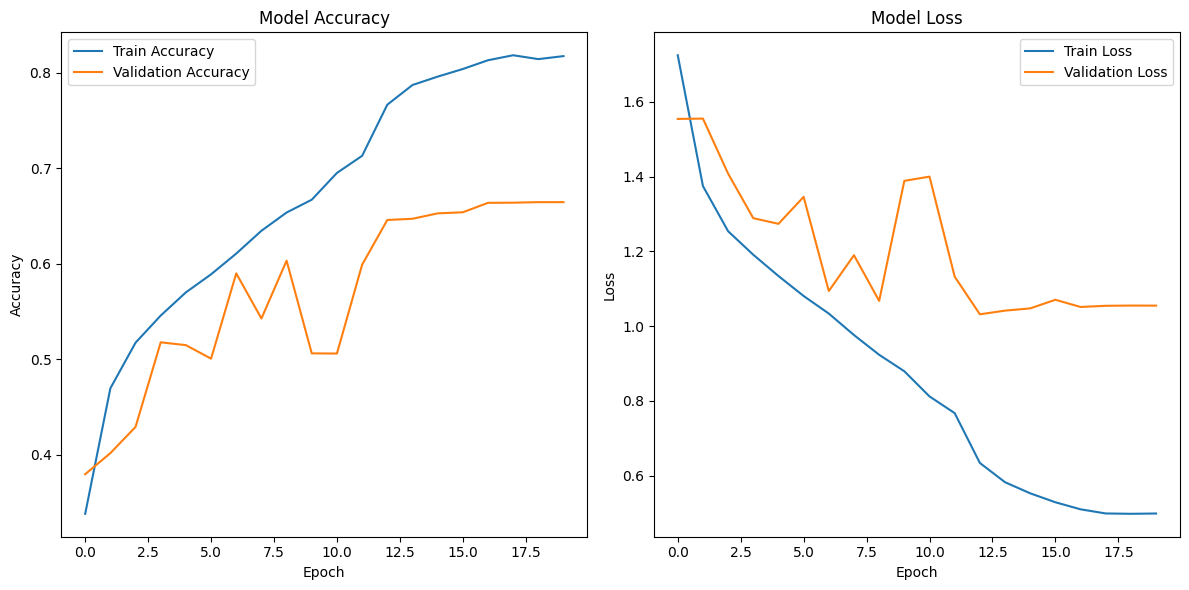

In [50]:
# Assuming `history` is the object returned from model.fit()
# history = model.fit(...)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Show the plots
plt.tight_layout()
plt.show()

Click 'Capture' to take a photo for emotion analysis


<IPython.core.display.Javascript object>

Photo taken! Analyzing emotions...
Found 1 faces
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
Raw prediction values:
Class 0: 21.09%
Class 1: 0.43%
Class 2: 6.77%
Class 3: 13.94%
Class 4: 13.65%
Class 5: 41.21%
Class 6: 2.91%
Analysis complete! Here's the result:


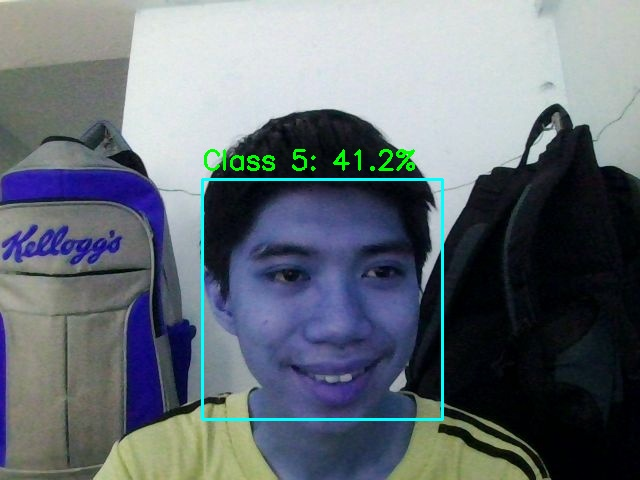

Here's the 48x48 grayscale face used for prediction:


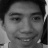

In [62]:
from google.colab import files
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import io
import os

# Download the Haar cascade file for face detection if needed
!wget -q -O haarcascade_frontalface_default.xml https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

# Function to take a photo using JavaScript
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Function to analyze the photo and show raw predictions
def analyze_emotion(image_path):
  # Load face detector
  face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

  # Load model
  model = load_model('my_model.keras')

  # Read image
  image = cv2.imread(image_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Detect faces
  faces = face_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

  # No faces detected
  if len(faces) == 0:
    print("No faces found in the image")
    return image

  print(f"Found {len(faces)} faces")

  # Process each face
  for (x, y, w, h) in faces:
    # Draw rectangle
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 255), 2)

    # Extract face ROI
    roi_gray = gray[y:y+h, x:x+w]

    # Resize to 48x48 as expected by your model
    roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

    # Prepare for prediction
    roi = roi_gray.astype('float')/255.0

    # Check if model expects a channel dimension
    input_shape = model.input_shape
    if len(input_shape) == 4 and (input_shape[3] == 1 or input_shape[3] is None):
      roi = np.expand_dims(roi, axis=-1)

    roi = np.expand_dims(roi, axis=0)

    # Make prediction
    prediction = model.predict(roi)[0]

    # Print raw prediction values
    print("Raw prediction values:")
    for i, value in enumerate(prediction):
      print(f"Class {i}: {value * 100:.2f}%")

    # Get the index with highest probability
    max_index = np.argmax(prediction)
    confidence = prediction[max_index] * 100

    # Display index with the highest probability
    label = f"Class {max_index}: {confidence:.1f}%"
    cv2.putText(image, label, (x, y-10),
               cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

  return image

# Function to display an OpenCV image in Colab
def show_image(img):
  if len(img.shape) == 2:
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  else:
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  is_success, buffer = cv2.imencode(".jpg", rgb_img)
  io_buf = io.BytesIO(buffer)
  display(Image(data=io_buf.getvalue()))

print("Click 'Capture' to take a photo for emotion analysis")
try:
  # Take a photo
  photo_filename = take_photo()
  print("Photo taken! Analyzing emotions...")

  # Analyze the photo
  result_image = analyze_emotion(photo_filename)

  if result_image is not None:
    # Save and display result
    cv2.imwrite('emotion_result.jpg', result_image)
    print("Analysis complete! Here's the result:")
    show_image(result_image)

    # Also show the processed face
    gray = cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) > 0:
      x, y, w, h = faces[0]
      face = gray[y:y+h, x:x+w]
      face_resized = cv2.resize(face, (48, 48), interpolation=cv2.INTER_AREA)
      cv2.imwrite('processed_face.jpg', face_resized)
      print("Here's the 48x48 grayscale face used for prediction:")
      show_image(face_resized)

except Exception as e:
  print(f"An error occurred: {str(e)}")
  import traceback
  traceback.print_exc()